# Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV

# Upload & View Dataset

In [ ]:
DATA_PATH = "DATA_WATER_SUPPLY_STATISTICS.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(190, 37)


,Provinsi,Tahun,Jumlah_Air_Bersih,Kapasitas_Produksi_Potensial_Perusahaan_Air_Bersih,Kapasitas_Produksi_Efektif,Efektifitas_Produksi_Air_Bersih_Perusahaan_Air_Bersih,Jumlah_Pekerja_Perusahaan_Air_Bersih,Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Tingkat_SLTA,Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Diatas_SLTA,Jumlah_Pekerja_Non_Teknis_Perusahaan_Air_Bersih,...,Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial,Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga_Perusahaan_Air_Bersih,Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri_Perusahaan_Air_Bersih,Volume_Air_Bersih_Yang_Disalurkan_ke_Pelanggan_Khusus_dan_Pelanggan_Lainnya_Perusahaan_Air_Bersih,Nilai_Air_Bersih_Yang_Disalurkan_Perusahaan_Air_Bersih \n,Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial,Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga,Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri,Nilai_Air_Bersih_yang_Disalurkan_ke_Pelanggan_Khusus_dan_Pelangan_Lainnya,Nilai_Pendapatan_dari_Kegiatan_Lain_Perusahaan_Air_Bersih
0,Aceh,2019,18,4.434,3.489,"78,69",1.186,485,122,579,...,"1,132","35,127","3,38",1.239,"152,839","2,737","128,424","17,869","3,808",23.891
1,Sumatera Utara,2019,42,12.896,11.484,"89,05",4.104,1.264,369,2.471,...,"12,172","203,608","31,473",764,"936,629","14,464","716,765","198,559","6,841",95.056
2,Sumatera Barat,2019,18,6.012,4.272,"71,06",1.425,661,146,618,...,"2,808","66,135","9,063",748,"309,177","4,554","248,85","52,127","3,646",40.523
3,Riau,2019,26,2.462,1.592,"64,66",978,527,90,361,...,311,"14,476","2,29",238,"76,836",941,"57,985","16,797","1,112",7.506
4,Jambi,2019,11,4.542,3.418,"75,25",1.421,646,175,600,...,"1,169","32,768","3,486",160,"165,555","3,822","136,726","23,936","1,072",10.926


# Dataset Overview

## Cek Tipe Data

In [ ]:
# Menampilkan tipe data setiap kolom
print("Tipe data per kolom:\n")
print(df.dtypes)

Tipe data per kolom:

Provinsi                                                                                                   object
Tahun                                                                                                       int64
Jumlah_Air_Bersih                                                                                          object
Kapasitas_Produksi_Potensial_Perusahaan_Air_Bersih                                                         object
Kapasitas_Produksi_Efektif                                                                                 object
Efektifitas_Produksi_Air_Bersih_Perusahaan_Air_Bersih                                                      object
Jumlah_Pekerja_Perusahaan_Air_Bersih                                                                       object
Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Tingkat_SLTA                                object
Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Dia

Hasil pengecekan tipe data menunjukkan bahwa kolom Provinsi dan Tahun sudah sesuai, namun seluruh kolom numerik lainnya masih terdeteksi sebagai tipe object

## Cek Missing Values & Duplicates

In [ ]:
import pandas as pd

# --- 1. Cek Missing Values ---
missing_summary = (
    df.isna().sum()
    .reset_index()
    .rename(columns={'index': 'Kolom', 0: 'Jumlah_Missing'})
)
missing_summary["Persentase_Missing"] = (missing_summary["Jumlah_Missing"] / len(df) * 100).round(2)

print("=== Ringkasan Missing Values ===")
print(missing_summary.to_string(index=False))

# --- 2. Cek Data Duplikat ---
duplicate_count = df.duplicated().sum()

print("\n=== Jumlah Data Duplikat ===")
print(f"Total duplikat: {duplicate_count}")

# --- 3. (Opsional) Menampilkan baris duplikat jika ada ---
if duplicate_count > 0:
    print("\nBaris duplikat yang terdeteksi:")
    display(df[df.duplicated(keep=False)])
else:
    print("Tidak ada baris duplikat ditemukan ✅")

=== Ringkasan Missing Values ===
                                                                                                  Kolom  Jumlah_Missing  Persentase_Missing
                                                                                               Provinsi               0                0.00
                                                                                                  Tahun               0                0.00
                                                                                      Jumlah_Air_Bersih               0                0.00
                                                     Kapasitas_Produksi_Potensial_Perusahaan_Air_Bersih               4                2.11
                                                                             Kapasitas_Produksi_Efektif               4                2.11
                                                  Efektifitas_Produksi_Air_Bersih_Perusahaan_Air_Bersih               4        

struktur data sudah rapi: di (Provinsi, Tahun) lengkap dan tidak duplikat.

Kualitas data cukup baik: Missing berada di rentang 1,58%–4,21%, tergolong rendah-sedang.

# Data Cleansing

## Handle Missing Values

In [ ]:
# Asumsikan kolomnya bernama 'Provinsi' (ubah kalau berbeda)
region_col = 'Provinsi'  # ganti sesuai nama kolom sebenarnya

# 1️⃣ Hapus baris yang bukan Papua tapi mengandung kata 'Papua' (contoh: Papua Barat, Papua Tengah, Papua Selatan)
# --- Hapus baris provinsi turunan Papua ---

# Daftar provinsi yang mau dihapus
hapus_papua = [
    "Papua Pegunungan",
    "Papua Tengah",
    "Papua Selatan",
    "Papua Barat Daya",
    "Papua Barat"
]

# Pastikan kolom provinsi lowercase dulu untuk pencocokan robust
df['Provinsi'] = df['Provinsi'].str.strip()

# Hapus provinsi yang tidak diinginkan
df = df[~df['Provinsi'].isin(hapus_papua)]

# Cek hasil
print("Daftar provinsi tersisa setelah cleansing:")
print(df['Provinsi'].unique())

print("\nJumlah baris setelah penghapusan:", df.shape[0])

# 2️⃣ Tangani missing values
#    - Untuk kolom numerik → isi dengan median
#    - Untuk kolom kategori → isi dengan modus (most frequent)
for col in df.columns:
    if df[col].dtype.kind in 'biufc':  # numerik
        df[col] = df[col].fillna(df[col].median())
    else:  # kategorikal / object
        df[col] = df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown')

# Cek hasil
print(f"Jumlah baris setelah filter Papua: {len(df)}")
print("Jumlah missing values setelah imputasi:")
print(df.isna().sum().sort_values(ascending=False))

Daftar provinsi tersisa setelah cleansing:
['Aceh' 'Sumatera Utara' 'Sumatera Barat' 'Riau' 'Jambi'
 'Sumatera Selatan' 'Bengkulu' 'Lampung' 'Kepulauan Bangka Belitung'
 'Kepulauan Riau' 'DKI Jakarta' 'Jawa Barat' 'Jawa Tengah'
 'D.I Yogyakarta' 'Jawa Timur' 'Banten' 'Bali' 'Nusa Tenggara Barat'
 'Nusa Tenggara Timur' 'Kalimantan Barat' 'Kalimantan Tengah'
 'Kalimantan Selatan' 'Kalimantan Timur' 'Kalimantan Utara'
 'Sulawesi Utara' 'Sulawesi Tengah' 'Sulawesi Selatan' 'Sulawesi Tenggara'
 'Gorontalo' 'Sulawesi Barat' 'Maluku' 'Maluku Utara' 'Papua']

Jumlah baris setelah penghapusan: 165
Jumlah baris setelah filter Papua: 165
Jumlah missing values setelah imputasi:
Provinsi                                                                                                   0
Tahun                                                                                                      0
Jumlah_Air_Bersih                                                                                          

seluruh data sudah lengkap tanpa nilai yang hilang (missing value = 0 untuk semua kolom). Jumlah provinsi yang valid sebanyak 33 provinsi, dengan total 165 baris data, yang menunjukkan dataset sudah rapi dan konsisten untuk analisis (33 provinsi × 5 tahun).

## Handle Data Type

In [ ]:
# 2️⃣ Konversi otomatis untuk kolom numerik yang terbaca sebagai object (misal '1.234' atau '12,5')
#    Langkah:
#    - hilangkan tanda koma/ribuan
#    - ubah ke float
for col in df.columns:
    if df[col].dtype == 'object':
        # Coba ubah string numerik jadi float
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .str.replace(r'[^0-9.\-]', '', regex=True)
        )
        # Coba konversi
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass  # biarkan tetap string kalau gagal

# 3️⃣ Ubah kolom kategori (non-numerik) jadi category dtype
cat_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        cat_cols.append(col)

# 4️⃣ (Opsional) Ubah kolom waktu ke datetime
time_candidates = ['tahun','year','periode','tanggal','tgl','date']
for c in df.columns:
    if c.lower() in time_candidates:
        df[c] = pd.to_datetime(df[c], errors='coerce', format='%Y', utc=True)
        print(f"Kolom {c} dikonversi ke datetime")

# 5️⃣ Cek hasil akhir
print("\nTipe data setelah konversi:")
print(df.dtypes)

print("\nKolom kategori:", cat_cols)

Kolom Tahun dikonversi ke datetime

Tipe data setelah konversi:
Provinsi                                                                                                              category
Tahun                                                                                                      datetime64[ns, UTC]
Jumlah_Air_Bersih                                                                                                      float64
Kapasitas_Produksi_Potensial_Perusahaan_Air_Bersih                                                                     float64
Kapasitas_Produksi_Efektif                                                                                             float64
Efektifitas_Produksi_Air_Bersih_Perusahaan_Air_Bersih                                                                  float64
Jumlah_Pekerja_Perusahaan_Air_Bersih                                                                                   float64
Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yan

melakukan penyesuaian tipe data agar sesuai dengan karakteristik variabel dan siap digunakan untuk analisis serta pemodelan.

## Rename Column

In [ ]:
df = df.rename(columns={
    'Provinsi': 'provinsi',
    'Tahun': 'tahun',
    'Jumlah_Air_Bersih': 'air_bersih',
    'Kapasitas_Produksi_Potensial_Perusahaan_Air_Bersih': 'kapasitas_potensial',
    'Kapasitas_Produksi_Efektif': 'kapasitas_efektif',
    'Efektifitas_Produksi_Air_Bersih_Perusahaan_Air_Bersih': 'efektivitas_produksi',
    'Jumlah_Pekerja_Perusahaan_Air_Bersih': 'jml_pekerja',
    'Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Tingkat_SLTA': 'pekerja_teknis_slta',
    'Jumlah_Pekerja_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Diatas_SLTA': 'pekerja_teknis_diploma',
    'Jumlah_Pekerja_Non_Teknis_Perusahaan_Air_Bersih': 'pekerja_non_teknis',
    'Jumlah_Pekerja_Non_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Sampai_Dengan_Tingkat_SLTA': 'non_teknis_slta',
    'Jumlah_Pekerja_Non_Teknis_Perusahaan_Air_Bersih_Yang_Berpendidikan_Diatas_Tingkat_SLTA': 'non_teknis_diploma',
    'Balas_Jasa_Karyawan_Perusahaan_Air_Bersih': 'balas_jasa',
    'Biaya_Bahan_Bakar_dan_Pelumas_yang_Digunakan_Perusahaan_Air_Bersih': 'biaya_bahan_bakar',
    'Biaya_Listrik_Perusahaan_Air_Bersih': 'biaya_listrik',
    'Biaya_Bahan-Bahan_Kimia_Perusahaan_Air_Bersih': 'biaya_kimia',
    'Biaya_Penggunaan_Alat_Tulis_dan_Keperluan_Kantor_Perusahaan_Air_Bersih': 'biaya_atk',
    'Biaya_Penggunaan_Suku_Cadang_dan_Pemeliharaan_Kecil_Barang_Modal_Perusahaan_Air_Bersih': 'biaya_suku_cadang',
    'Biaya_Sewa_Bangunan_Mesin_Alat-alat_dan_Kendaraan_Perusahaan_Air_Bersih': 'biaya_sewa',
    'Biaya_Jasa_jasa_Pengeluaran_Lainnya_Perusahaan_Air_Bersih': 'biaya_jasa_lain',
    'Biaya_Operasional_Perusahaan_Air_Bersih': 'biaya_operasional',
    'Jumlah_Pelanggan_Perusahaan_Air_Bersih': 'pelanggan_total',
    'Jumlah_Pelanggan_Kelompok_Sosial_Perusahaan_Air_Bersih': 'pelanggan_sosial',
    'Jumlah_Pelanggan_Kelompok_Non_Niaga_Perusahaan_Air_Bersih': 'pelanggan_non_niaga',
    'Jumlah_Pelanggan_Kelompok_Niaga_dan_Industri_Perusahaan_Air_Bersih': 'pelanggan_niaga',
    'Jumlah_Pelanggan_Kelompok_Khusus_dan_Pelanggan_Lainnya': 'pelanggan_khusus',
    'Volume_Air_Bersih_yang_Disalurkan_Perusahaan_Air_Bersih': 'volume_total',
    'Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial': 'volume_sosial',
    'Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga_Perusahaan_Air_Bersih': 'volume_non_niaga',
    'Volume_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri_Perusahaan_Air_Bersih': 'volume_niaga',
    'Volume_Air_Bersih_Yang_Disalurkan_ke_Pelanggan_Khusus_dan_Pelanggan_Lainnya_Perusahaan_Air_Bersih': 'volume_khusus',
    'Nilai_Air_Bersih_Yang_Disalurkan_Perusahaan_Air_Bersih': 'nilai_total',
    'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial': 'nilai_sosial',
    'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga': 'nilai_non_niaga',
    'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri': 'nilai_niaga',
    'Nilai_Air_Bersih_yang_Disalurkan_ke_Pelanggan_Khusus_dan_Pelangan_Lainnya': 'nilai_khusus',
    'Nilai_Pendapatan_dari_Kegiatan_Lain_Perusahaan_Air_Bersih': 'pendapatan_lain'
})

# Cek hasil
print("Kolom baru (singkat):")
print(df.columns.tolist())

Kolom baru (singkat):
['provinsi', 'tahun', 'air_bersih', 'kapasitas_potensial', 'kapasitas_efektif', 'efektivitas_produksi', 'jml_pekerja', 'pekerja_teknis_slta', 'pekerja_teknis_diploma', 'pekerja_non_teknis', 'non_teknis_slta', 'non_teknis_diploma', 'balas_jasa', 'biaya_bahan_bakar', 'biaya_listrik', 'biaya_kimia', 'biaya_atk', 'biaya_suku_cadang', 'biaya_sewa', 'biaya_jasa_lain', 'Biaya_Operasional_Perusahaan_Air_Bersih ', 'Jumlah_Pelanggan_Perusahaan_Air_Bersih ', 'pelanggan_sosial', 'Jumlah_Pelanggan_Kelompok_Non_Niaga_Perusahaan_Air_Bersih ', 'pelanggan_niaga', 'pelanggan_khusus', 'volume_total', 'volume_sosial', 'volume_non_niaga', 'volume_niaga', 'volume_khusus', 'Nilai_Air_Bersih_Yang_Disalurkan_Perusahaan_Air_Bersih                                               \n', 'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial ', 'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga ', 'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri ', 'Nilai_Air_Bersih

# EDA

## Statistik Deskriptif

In [ ]:
# Statistik numerik
print("=== STATISTIK NUMERIK ===")
desc = df.describe().T
desc['range'] = desc['max'] - desc['min']
desc[['mean', 'std', 'min', 'max', 'range']].round(2)

=== STATISTIK NUMERIK ===


,mean,std,min,max,range
air_bersih,16.32,11.18,3.00,44.00,41.00
kapasitas_potensial,39.49,164.66,1.05,985.00,983.95
kapasitas_efektif,51.25,174.51,1.04,972.00,970.96
efektivitas_produksi,76.58,11.78,46.09,96.59,50.50
jml_pekerja,242.94,324.52,1.00,992.00,991.00
pekerja_teknis_slta,358.21,267.14,1.00,999.00,998.00
pekerja_teknis_diploma,215.87,228.02,1.01,943.00,941.99
pekerja_non_teknis,367.06,280.09,1.02,990.00,988.98
non_teknis_slta,278.58,200.68,1.18,930.00,928.82
non_teknis_diploma,222.30,205.44,1.06,989.00,987.94


Beberapa variabel seperti kapasitas potensial, kapasitas efektif, dan jumlah pekerja memiliki standar deviasi tinggi, menandakan variasi data yang besar antar sampel.

Variabel seperti air_bersih dan efektivitas_produksi memiliki penyebaran yang lebih kecil, artinya datanya lebih konsisten.

Nilai range yang besar (mendekati 1000) pada banyak kolom menunjukkan adanya skala data yang sangat lebar antara nilai terkecil dan terbesar.

## Distribusi Variabel

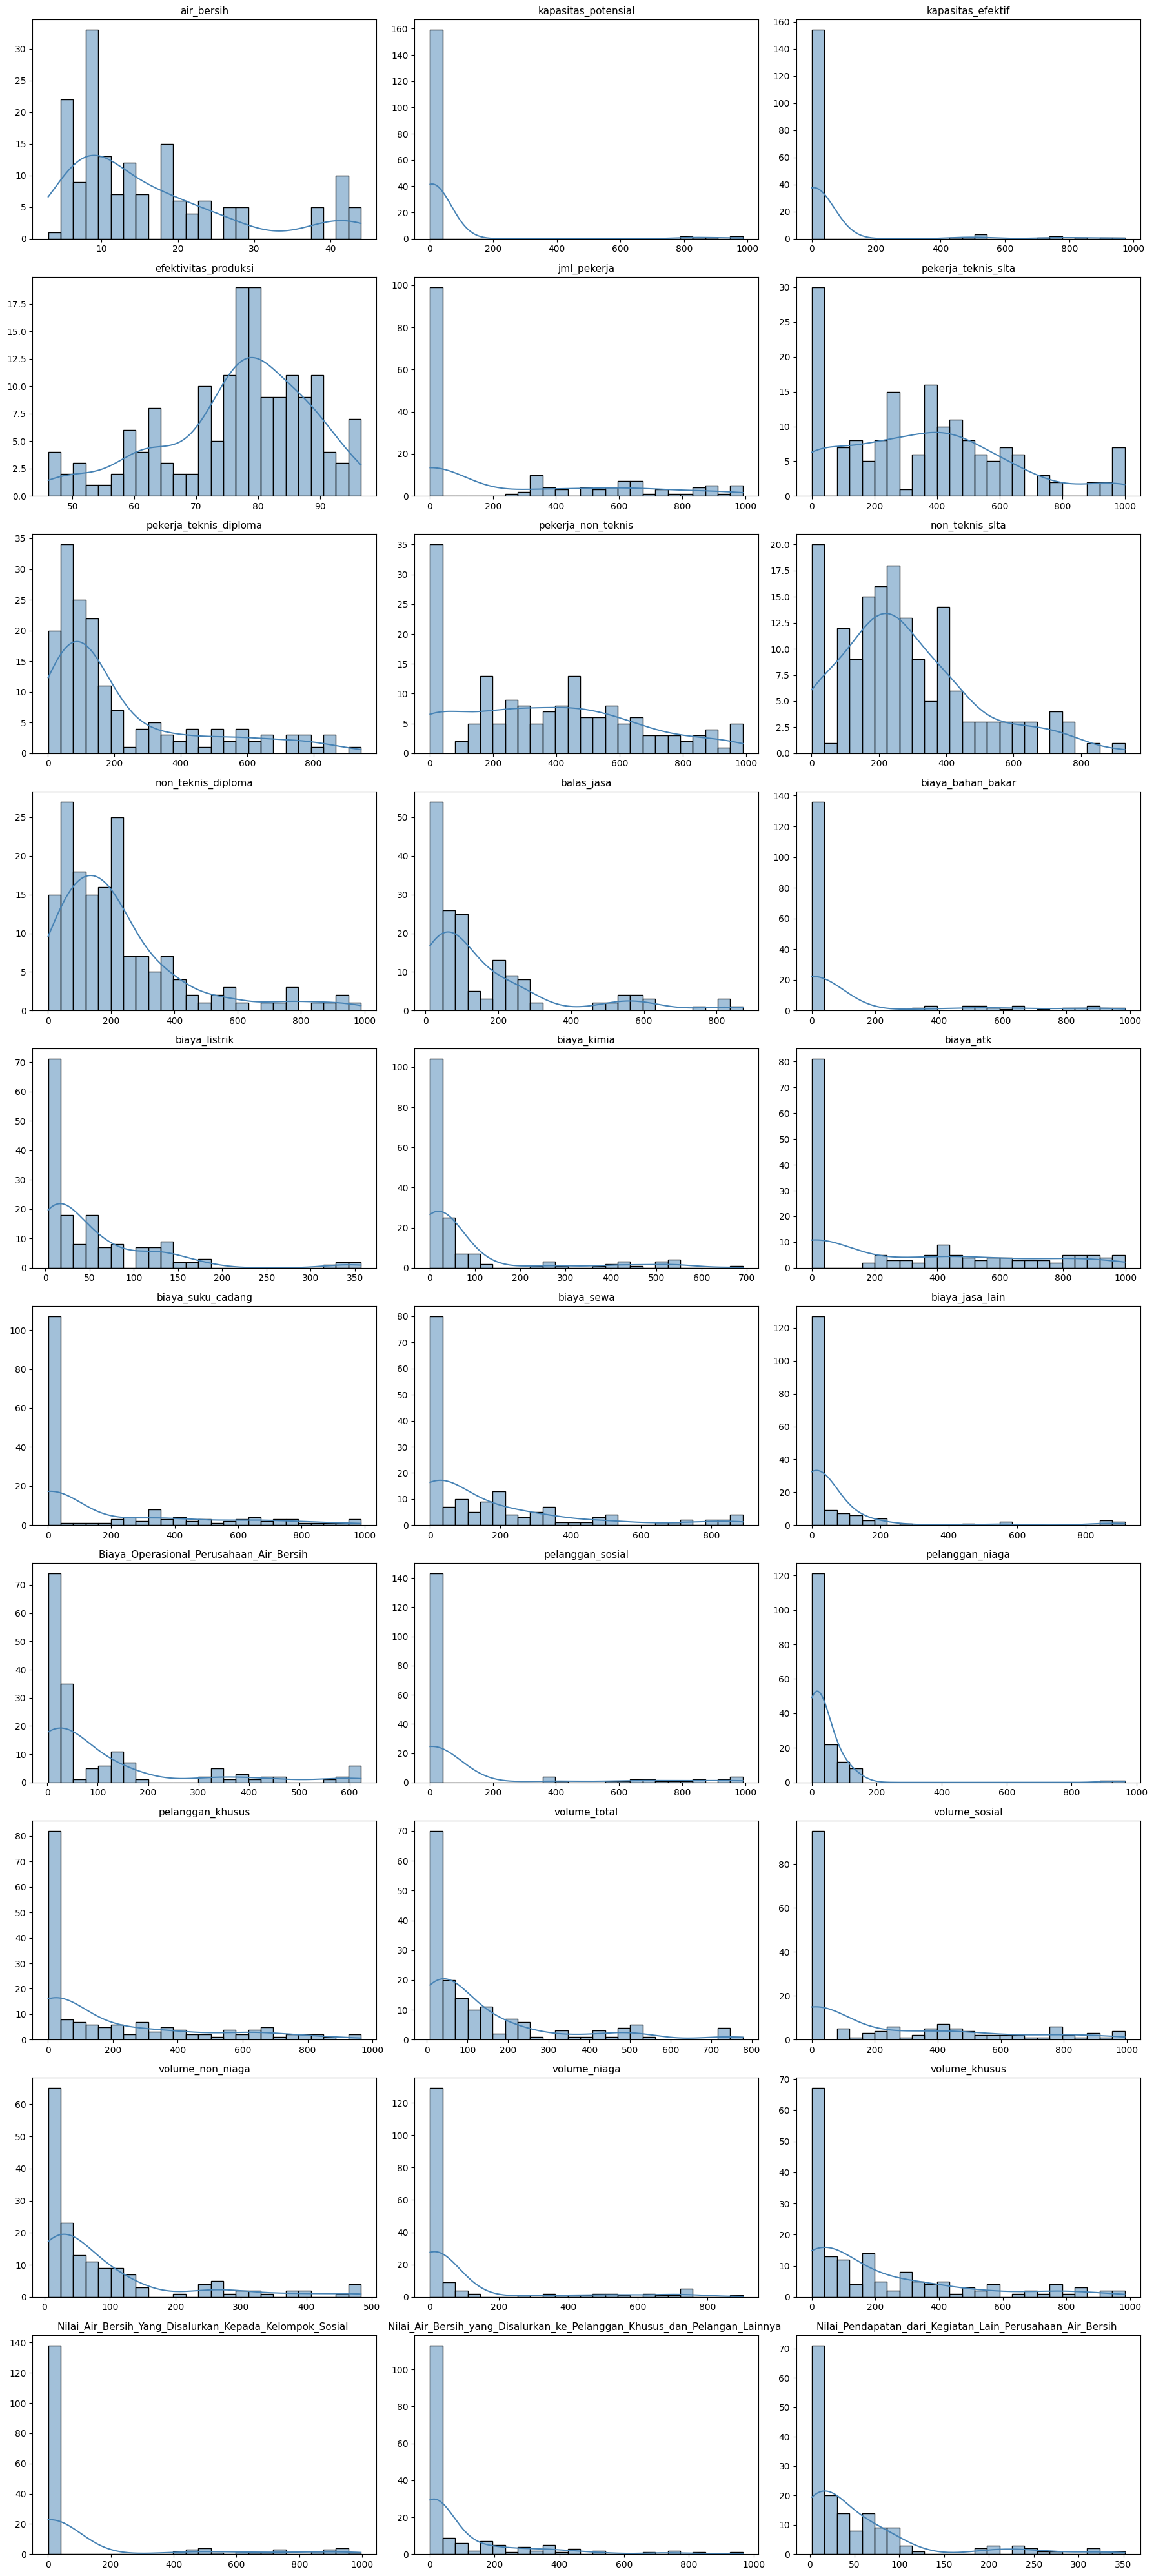

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ambil kolom numerik aja
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Setup grid untuk histogram
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=25, color='steelblue')
    plt.title(col, fontsize=11)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Dominasi Miring Kanan (Right-Skewed): Sebagian besar kolom numerik menunjukkan distribusi yang miring ke kanan. Ini adalah karakteristik utama.

Konsentrasi Nilai Rendah: Distribusi miring ke kanan berarti mayoritas data terkonsentrasi pada nilai-nilai yang lebih rendah (dekat dengan nol) dan frekuensi menurun drastis seiring nilai data membesar.

Kesimpulan: Data mencerminkan pola umum di mana ada banyak event atau entitas bernilai kecil/standar, dan sangat sedikit entitas atau event bernilai sangat tinggi.

## Boxplot

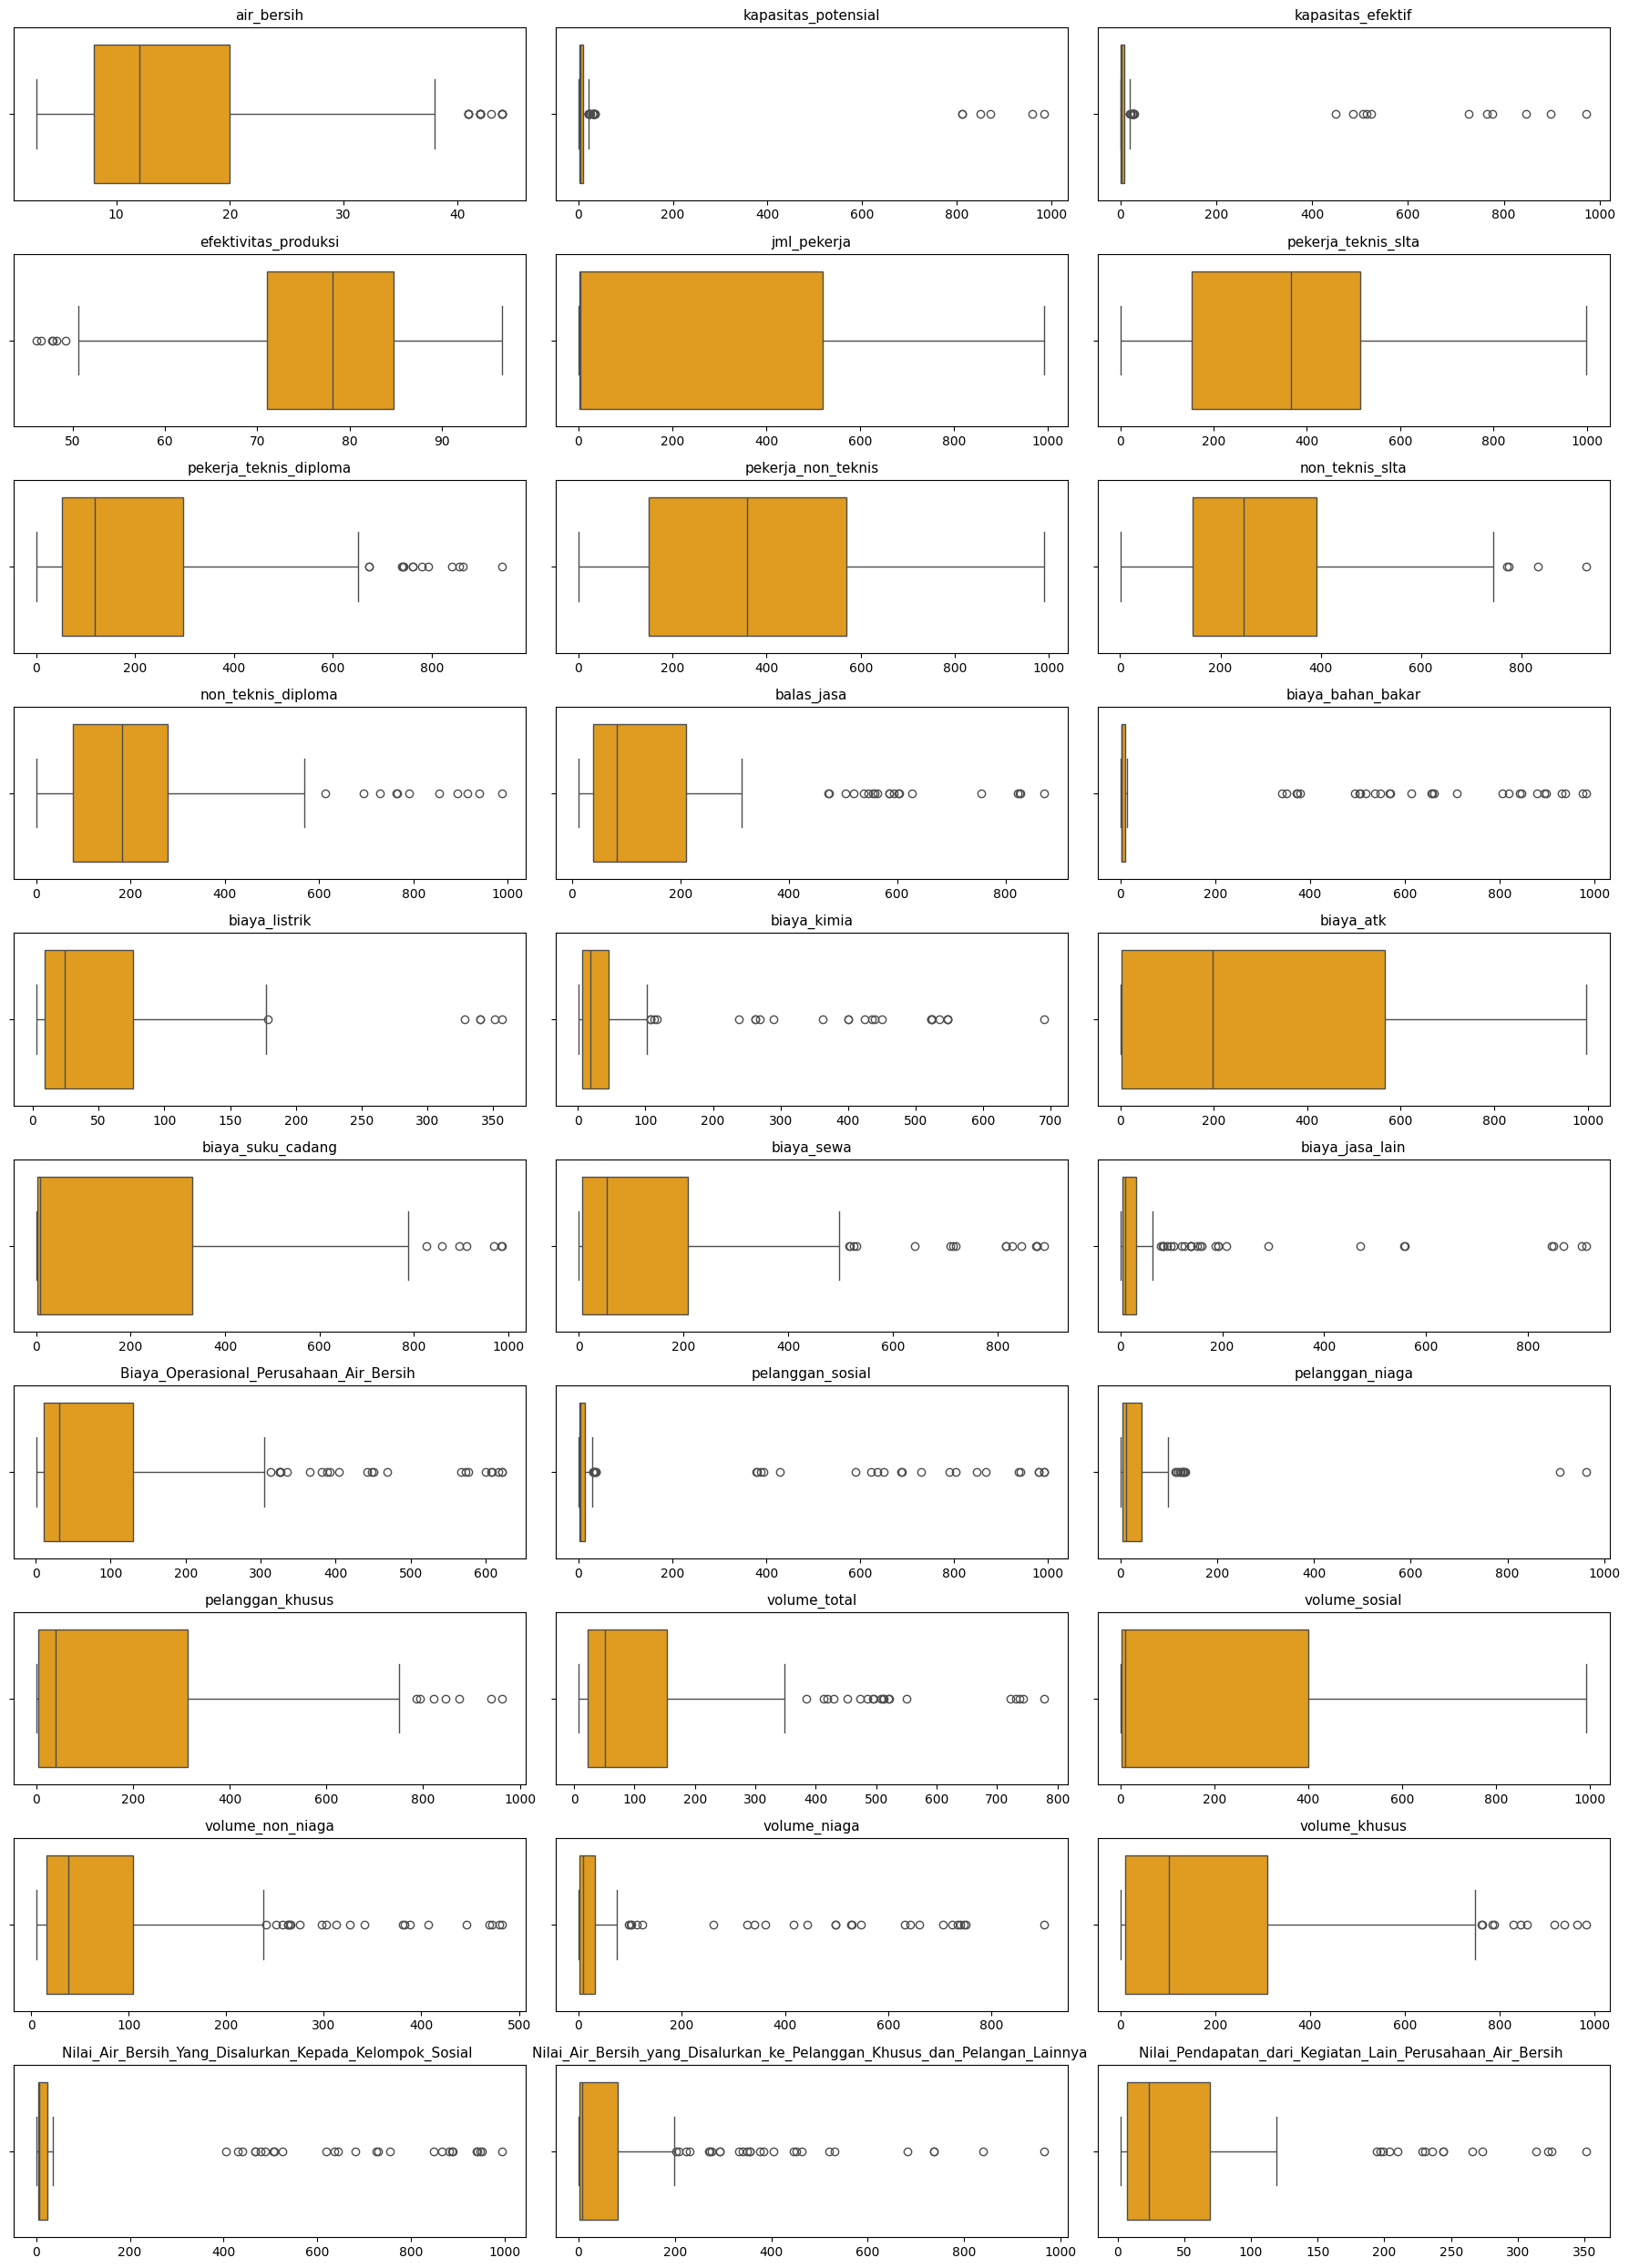

In [ ]:
plt.figure(figsize=(18, n_rows * 2.5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], color='orange')
    plt.title(col, fontsize=11)
    plt.xlabel('')
plt.tight_layout()
plt.show()

Garis tengah (median) dari kotak-kotak tersebut mayoritas berada di nilai rendah, namun ekor (whisker) dan titik-titik outlier memanjang jauh ke kanan, mengonfirmasi bahwa sebagian besar data terkonsentrasi di nilai kecil, sementara sebagian kecil data memiliki nilai yang ekstrem (tinggi).

## Distribusi Berdasarkan Provinsi

/tmp/ipython-input-1542252840.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prov_avg = df.groupby('provinsi')[target].mean().sort_values(ascending=False)


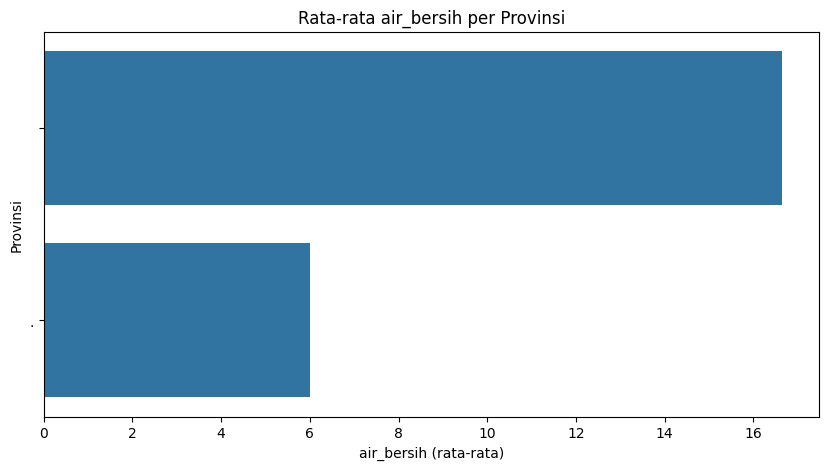

In [ ]:
target = 'air_bersih'

plt.figure(figsize=(10,5))
prov_avg = df.groupby('provinsi')[target].mean().sort_values(ascending=False)
sns.barplot(y=prov_avg.index, x=prov_avg.values)
plt.title(f'Rata-rata {target} per Provinsi')
plt.xlabel(f'{target} (rata-rata)')
plt.ylabel('Provinsi')
plt.show()

Provinsi yang berada di bar atas memiliki rata-rata ketersediaan atau penggunaan air_bersih sekitar 2,7 kali lipat lebih tinggi dibandingkan Provinsi yang berada di bar bawah.

## Tren Waktu Per tahun

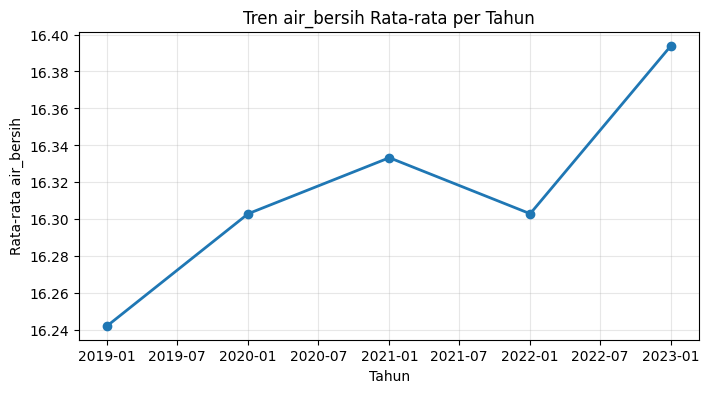

In [ ]:
plt.figure(figsize=(8,4))
df_group = df.groupby('tahun')[target].mean()
plt.plot(df_group.index, df_group.values, marker='o', linewidth=2)
plt.title(f'Tren {target} Rata-rata per Tahun')
plt.xlabel('Tahun')
plt.ylabel(f'Rata-rata {target}')
plt.grid(True, alpha=0.3)
plt.show()

Tren Jangka Panjang: Secara keseluruhan (dari 2019 ke 2023), rata-rata air_bersih menunjukkan tren peningkatan yang bertahap, dari sekitar 16.24 menjadi 16.39.

Pergerakan Tahun ke Tahun:

Terjadi kenaikan stabil dari tahun 2019 hingga mencapai puncaknya di 2021 (sekitar 16.34).

Kemudian terjadi sedikit penurunan pada tahun 2022 (sekitar 16.30).

Akhirnya, terjadi kenaikan tajam dan mencapai rata-rata tertinggi di 2023 (sekitar 16.39).

Variasi Relatif Kecil: Meskipun ada tren naik, variasi dalam nilai rata-rata dari tahun ke tahun sangat kecil (hanya berkisar antara 16.24 hingga 16.39).

Kesimpulan : Rata-rata air_bersih menunjukkan peningkatan over time, dengan nilai tertinggi tercatat pada tahun 2023.

## Korelasi Antar Variabel

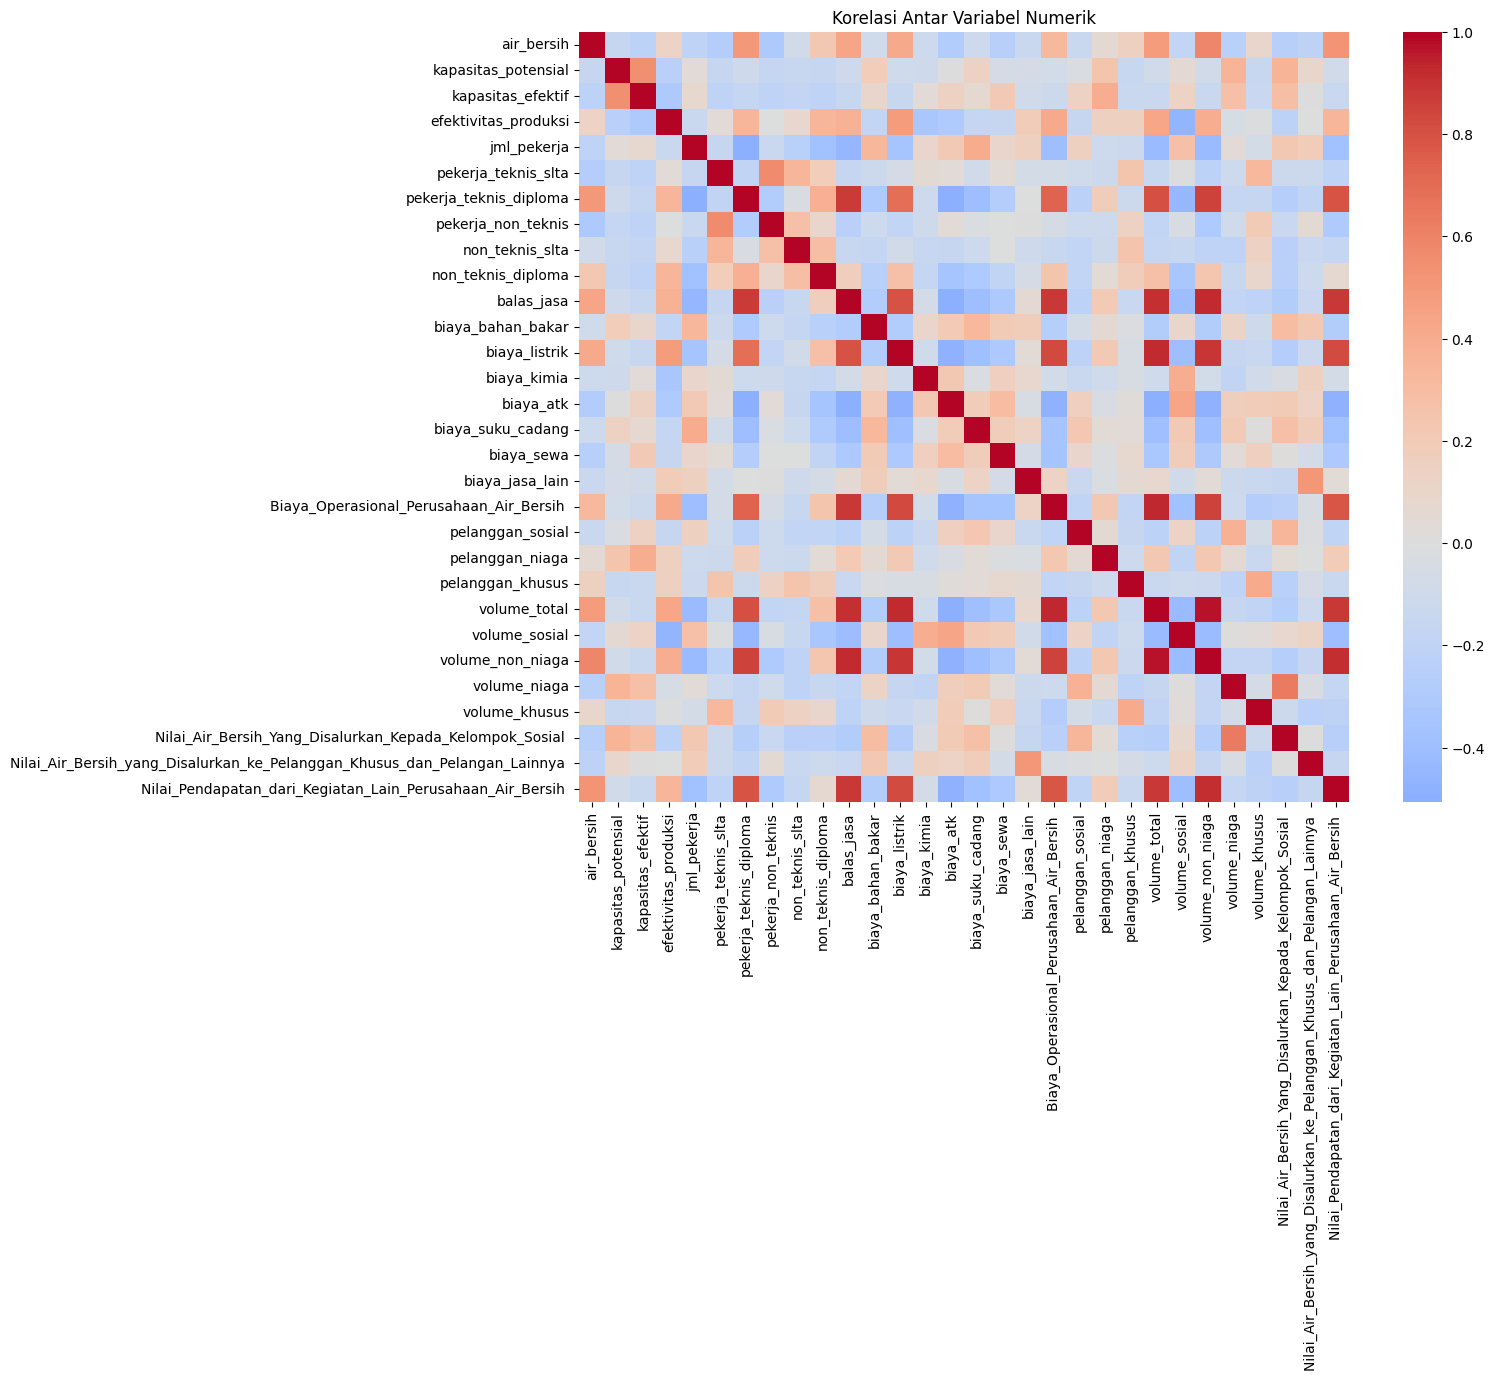


=== 10 Fitur dengan Korelasi Tertinggi terhadap Jumlah Air Bersih ===
volume_non_niaga                                              0.582870
Nilai_Pendapatan_dari_Kegiatan_Lain_Perusahaan_Air_Bersih     0.528285
pekerja_teknis_diploma                                        0.504643
volume_total                                                  0.491468
balas_jasa                                                    0.443847
biaya_listrik                                                 0.422879
Biaya_Operasional_Perusahaan_Air_Bersih                       0.322140
non_teknis_diploma                                            0.223509
pelanggan_khusus                                              0.151314
efektivitas_produksi                                          0.134907
Name: air_bersih, dtype: float64


In [ ]:
# Pilih kolom numerik saja
num_df = df.select_dtypes(include=[np.number])

# Korelasi matrix
corr = num_df.corr()

# Heatmap korelasi
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True)
plt.title('Korelasi Antar Variabel Numerik')
plt.show()

# 10 fitur paling berkorelasi dengan target
corr_target = corr[target].drop(target).sort_values(ascending=False)
print("\n=== 10 Fitur dengan Korelasi Tertinggi terhadap Jumlah Air Bersih ===")
print(corr_target.head(10))

Pola Kuat: Heatmap menunjukkan banyak area berwarna merah gelap (korelasi positif kuat) dan biru gelap (korelasi negatif kuat). Ini mengindikasikan adanya hubungan linier yang kuat antar banyak pasangan variabel, terutama dalam blok-blok besar (misalnya, semua variabel biaya berkorelasi positif kuat satu sama lain).

Korelasi Positif (Merah): Umumnya terjadi di antara variabel-variabel sejenis (contoh: Biaya-biaya, Volume-volume, Pekerja-pekerja).

Korelasi Negatif (Biru): Terdapat beberapa korelasi negatif yang perlu diperhatikan, meskipun tidak sekuat korelasi positif antar variabel sejenis.

Kesimpulan : Variabel volume yang disalurkan ke sektor non-niaga (volume_non_niaga) dan variabel pendapatan (Nilai_Pendapatan...) adalah faktor utama yang memiliki hubungan linier paling kuat dan positif dengan jumlah air_bersih.

## Insight Awal

In [ ]:
print("💡 Insight Awal:")
print("- Jumlah data:", df.shape[0], "baris dan", df.shape[1], "kolom.")
print("- Kolom waktu:", 'tahun' if 'tahun' in df.columns else 'tidak ada.')
print("- Kolom kategori:", df.select_dtypes('category').columns.tolist())
print("- Kolom numerik:", len(num_df.columns), "kolom numerik.")

if corr_target.abs().max() > 0.5:
    top_corr = corr_target.abs().idxmax()
    print(f"- Variabel paling berpengaruh terhadap jumlah air bersih: {top_corr} (r={corr_target[top_corr]:.2f})")
else:
    print("- Tidak ada variabel dengan korelasi kuat terhadap jumlah air bersih (r<0.5).")

💡 Insight Awal:
- Jumlah data: 165 baris dan 37 kolom.
- Kolom waktu: tahun
- Kolom kategori: ['provinsi', 'Jumlah_Pelanggan_Perusahaan_Air_Bersih ', 'Jumlah_Pelanggan_Kelompok_Non_Niaga_Perusahaan_Air_Bersih ', 'Nilai_Air_Bersih_Yang_Disalurkan_Perusahaan_Air_Bersih                                               \n', 'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Non_Niaga ', 'Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Niaga_dan_Industri ']
- Kolom numerik: 30 kolom numerik.
- Variabel paling berpengaruh terhadap jumlah air bersih: volume_non_niaga (r=0.58)


Ukuran Data: Dataset terdiri dari 165 baris (observasi) dan 37 kolom (variabel).

Variabel Kunci: Terdapat kolom waktu (tahun) dan 30 kolom numerik yang menjadi fokus utama analisis kuantitatif. Terdapat 6 kolom kategori yang memuat informasi pengelompokan (seperti provinsi dan berbagai jenis pelanggan serta nilai air bersih disalurkan).

Variabel Paling Berpengaruh: Variabel volume_non_niaga adalah fitur dengan korelasi linier terkuat terhadap jumlah air_bersih (sebagai target), dengan koefisien korelasi positif $r=0.58$. Ini menunjukkan bahwa volume air yang disalurkan ke sektor non-niaga memiliki hubungan yang cukup kuat dan positif dengan total air_bersih.

# Modelling

## Preprocessing Data

In [ ]:
target = 'air_bersih'

# Pisahkan fitur & target
X = df.drop(columns=[target, 'provinsi', 'tahun'], errors='ignore')
y = df[target]

# --- BERSIHKAN NILAI STRING DI KOLOM NUMERIK ---
# Hapus pemisah ribuan (.) dan ubah koma menjadi titik untuk desimal
for col in X.columns:
    X[col] = X[col].astype(str)                             # pastikan semua string dulu
    X[col] = X[col].str.replace('.', '', regex=False)        # hapus titik ribuan
    X[col] = X[col].str.replace(',', '.', regex=False)       # ubah koma jadi titik
    X[col] = pd.to_numeric(X[col], errors='coerce')          # ubah ke float, gagal -> NaN

# Jika masih ada kolom non-numerik, drop dulu
X = X.select_dtypes(include=['number'])

# --- SPLIT DATA ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data training:", X_train.shape, " | Data testing:", X_test.shape)


Data training: (132, 34)  | Data testing: (33, 34)


setelah proses preprocessing, data telah berhasil dibagi menjadi dua bagian:

132 baris data training digunakan untuk melatih model agar dapat mempelajari pola dari data historis.

33 baris data testing digunakan untuk menguji kemampuan model dalam memprediksi data baru.

Setiap data memiliki 34 variabel (fitur) yang sudah bersih dan siap digunakan.

## Model Baseline

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Model 2: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

# Evaluasi
def eval_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📊 {name}")
    print(f"R² Score   : {r2:.4f}")
    print(f"RMSE       : {rmse:.2f}")
    print(f"MAE        : {mae:.2f}")

eval_model(y_test, y_pred_rf, "Random Forest")
eval_model(y_test, y_pred_gb, "Gradient Boosting")



📊 Random Forest
R² Score   : 0.6528
RMSE       : 6.29
MAE        : 4.05

📊 Gradient Boosting
R² Score   : 0.7049
RMSE       : 5.80
MAE        : 4.10


model Gradient Boosting memiliki performa lebih baik dibanding Random Forest karena nilai R²-nya lebih tinggi (0.7049 vs 0.6528) dan RMSE-nya lebih kecil (5.80 vs 6.29), artinya prediksi model lebih akurat.
Meskipun MAE Random Forest sedikit lebih rendah (4.05 vs 4.10), perbedaannya kecil.
Secara keseluruhan, Gradient Boosting memberikan hasil prediksi yang lebih baik dalam menjelaskan variasi data jumlah air bersih.

## Feature Importance

/tmp/ipython-input-901912419.py:14: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


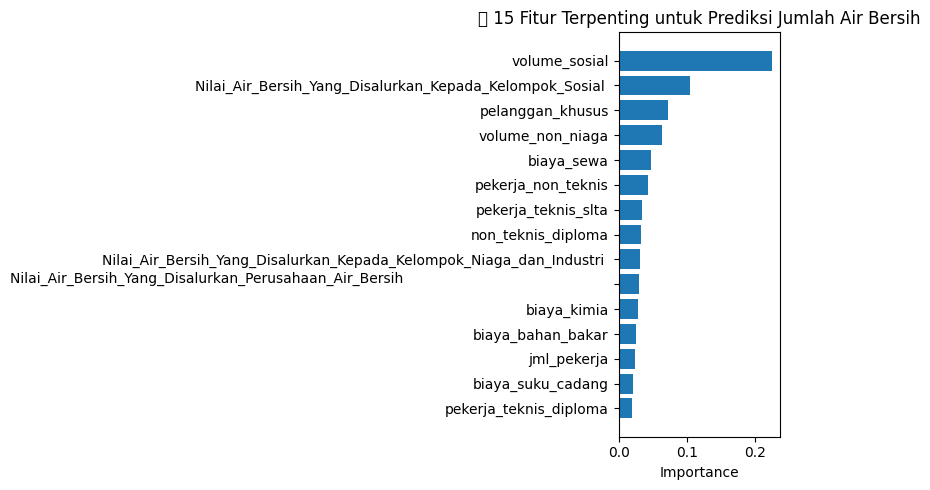

,feature,importance
24,volume_sosial,0.225404
29,Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelomp...,0.104571
22,pelanggan_khusus,0.072384
25,volume_non_niaga,0.064014
15,biaya_sewa,0.047009
6,pekerja_non_teknis,0.043252
4,pekerja_teknis_slta,0.034293
8,non_teknis_diploma,0.032252
31,Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelomp...,0.030689
28,Nilai_Air_Bersih_Yang_Disalurkan_Perusahaan_Ai...,0.030278


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil importance dari model terbaik (misal Random Forest)
importance = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_imp = feat_imp.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1])
plt.title('🔍 15 Fitur Terpenting untuk Prediksi Jumlah Air Bersih')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

feat_imp

Fitur paling berpengaruh: volume_sosial — importance ≈ 0.2254 (≈22.5%).

Fitur kedua: Nilai_Air_Bersih_Yang_Disalurkan_Kepada_Kelompok_Sosial — importance ≈ 0.1046 (≈10.5%).

Fitur ketiga: pelanggan_khusus — importance ≈ 0.0724 (≈7.2%).

Fitur keempat: volume_non_niaga — importance ≈ 0.0640 (≈6.4%).

Fitur kelima: biaya_sewa — importance ≈ 0.0470 (≈4.7%).

## Visualisasi

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


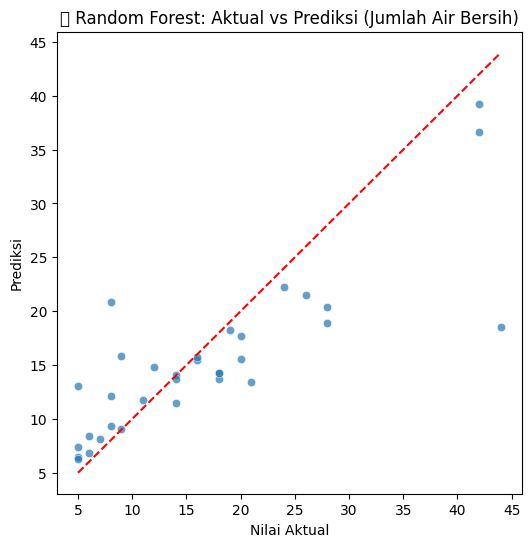

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Aktual')
plt.ylabel('Prediksi')
plt.title('📉 Random Forest: Aktual vs Prediksi (Jumlah Air Bersih)')
plt.show()

# Model Lanjutan

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


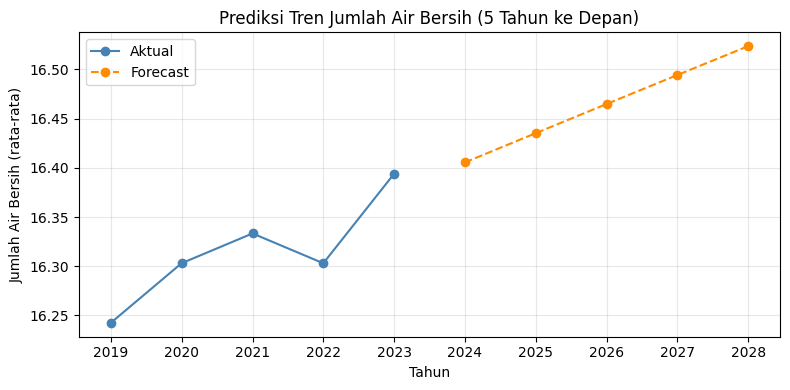

📈 Hasil Forecast 5 Tahun ke Depan:


,0
2024-01-01 00:00:00+00:00,16.406
2025-01-01 00:00:00+00:00,16.435
2026-01-01 00:00:00+00:00,16.465
2027-01-01 00:00:00+00:00,16.494
2028-01-01 00:00:00+00:00,16.524


In [ ]:
# === PREDIKSI TREN JUMLAH AIR BERSIH ===
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- 1. Agregasi rata-rata per tahun ---
df_year = df.groupby('tahun')['air_bersih'].mean()

# Pastikan index bertipe datetime (agar tidak muncul warning)
df_year.index = pd.to_datetime(df_year.index, format='%Y')

# --- 2. Fit model Holt-Winters (tanpa musiman, dengan tren redam) ---
model = ExponentialSmoothing(df_year, trend='add', seasonal=None, damped_trend=True)
fit = model.fit(optimized=True)

# --- 3. Forecast 5 tahun ke depan ---
forecast = fit.forecast(steps=5)

# --- 4. Visualisasi ---
plt.figure(figsize=(8,4))
plt.plot(df_year.index, df_year.values, label='Aktual', marker='o', color='steelblue')
plt.plot(forecast.index, forecast.values, label='Forecast', marker='o', color='darkorange', linestyle='--')
plt.title('Prediksi Tren Jumlah Air Bersih (5 Tahun ke Depan)', fontsize=12)
plt.xlabel('Tahun')
plt.ylabel('Jumlah Air Bersih (rata-rata)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5. Tampilkan hasil prediksi ---
print("📈 Hasil Forecast 5 Tahun ke Depan:")
display(forecast.round(3))


# DEPLOY

In [ ]:
import pickle
import json
import pandas as pd
from google.colab import files

# Asumsikan model terbaik adalah Random Forest (rf) dan scaler sudah ada
# Simpan model langsung di Colab lokal
with open('/content/model.pkl', 'wb') as f:
    pickle.dump(rf, f)  # Ganti 'rf' dengan nama model kamu (misal gb untuk Gradient Boosting)

# Simpan scaler
with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Simpan daftar fitur yang digunakan model (untuk input di Streamlit)
features = X.columns.tolist()  # X adalah DataFrame fitur kamu
with open('/content/features.json', 'w') as f:
    json.dump(features, f)

# Simpan dataset asli (untuk visualisasi di Streamlit)
df.to_csv('/content/DATA_WATER_SUPPLY_STATISTICS_clean.csv', index=False)

print("File berhasil disimpan di Colab lokal:")
print("- model.pkl")
print("- scaler.pkl")
print("- features.json")
print("- DATA_WATER_SUPPLY_STATISTICS_clean.csv")

# Download otomatis ke komputer kamu
files.download('/content/model.pkl')
files.download('/content/scaler.pkl')
files.download('/content/features.json')
files.download('/content/DATA_WATER_SUPPLY_STATISTICS_clean.csv')

print("File sudah didownload ke komputer kamu. Sekarang pindahkan ke folder proyek VSCode kamu.")


File berhasil disimpan di Colab lokal:
- model.pkl
- scaler.pkl
- features.json
- DATA_WATER_SUPPLY_STATISTICS_clean.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File sudah didownload ke komputer kamu. Sekarang pindahkan ke folder proyek VSCode kamu.
